In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table
from collections import Counter
import numpy as np
import scipy as sp
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from utilities import Util
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
import seaborn as sns

In [2]:
df = pd.read_csv('smiles_converted.csv')
df = df.rename(columns={'Name':'Molecule ChEMBL ID'})

In [3]:
df2 = pd.read_csv('Training-Data.csv')

In [4]:
df.head()

,Molecule ChEMBL ID,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL63786,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL35820,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL53711,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL53753,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL66031,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Check  Sparsity

In [5]:
a = (df.to_numpy() == 0).mean()
print("Sparsity of fingerprints data is {}".format(a))

Sparsity of fingerprints data is 0.7878854537511794


In [6]:
df2.shape

(5435, 6)

In [18]:
new = pd.merge(df2, df, on='Molecule ChEMBL ID')

In [19]:
new = new.drop(columns=['Smiles', "Molecule ChEMBL ID"])

In [20]:
new.head()

,CHEMBL614725,CHEMBL1957,CHEMBL2842,CHEMBL203,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Prepare the dataset

In [21]:
util_fn = Util(new, {'CHEMBL614725', 'CHEMBL1957', 'CHEMBL2842', 'CHEMBL203'})

In [22]:
target_ids = ['CHEMBL614725', 'CHEMBL1957', 'CHEMBL2842', 'CHEMBL203']
counts = {}

for t in target_ids:
    counts[util_fn.target_abbr_from_id(t)] = new[new[str(t)] == 1].shape[0]

print(counts)

{'MIA PaCa-2': 670, 'IGF-1': 812, 'mTOR': 1109, 'EGFR-erbB1': 2671}


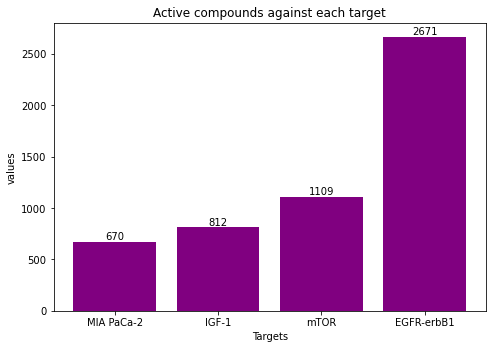

In [23]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0,0,1,1])
x_axis = list(counts.keys())
y_axis = list(counts.values())
ax.bar(x_axis,y_axis, color='purple')
for i in range(len(y_axis)):
    plt.annotate(str(y_axis[i]), xy=(x_axis[i],y_axis[i]), ha='center', va='bottom')
    plt.title("Active compounds against each target")
    plt.xlabel("Targets")
    plt.ylabel("values")

In [24]:
def get_dataset():
    y = new[target_ids]
    X = new.drop(columns=target_ids)
    return X, y

In [25]:
# load dataset
X, y = get_dataset()
n_inputs, n_outputs = X.shape[1], y.shape[1]
n_inputs

881

## PCA 

In [26]:
def transform_data(X_arg, n):
    print("transform_data is called", n)
    svd = TruncatedSVD(n_components=int(n - 1), n_iter=7, random_state=42)
    tr_X = svd.fit(X_arg)
    X_vals = tr_X.transform(X_arg)
    
    X_vals = pd.DataFrame(X_vals)
    print(X_vals.shape)
    return X_vals, n - 1

In [27]:
X_features, n_inputs_pca = transform_data(X, X.shape[1])
n_inputs_pca

transform_data is called 881
(5043, 880)


880

In [28]:
# Sparsity after transformation

a = (X_features.to_numpy() == 0).mean()
print("Sparsity of fingerprints data is {}".format(a))

Sparsity of fingerprints data is 0.022319416653146577


### Since after testing the results indicated no significant improvement by PCA, we will use the original dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model

In [30]:
def get_model_baseline(n_inputs, n_outputs ):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(20, input_dim=n_inputs,  kernel_initializer='he_uniform', activation='relu'))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    #model.add(tf.keras.layers.LSTM(300, activation='relu'))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs, activation='sigmoid'))
    model.compile( loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
    return model

In [31]:
from keras.layers import Dropout

x_train, Y_train = np.array(X_train), np.array(y_train)

#Reshape the data into 3-D array
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))
x_train.shape
    

(4034, 881, 1)

In [32]:
#model = get_model_lstm()
model = get_model_baseline(n_inputs, n_outputs )

In [33]:
history = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
127/127 [==============================] - 1s 2ms/step - loss: 0.4710 - accuracy: 0.5371 - auc: 0.7745
Epoch 2/200
127/127 [==============================] - 0s 2ms/step - loss: 0.2868 - accuracy: 0.7557 - auc: 0.9277
Epoch 3/200
127/127 [==============================] - 0s 2ms/step - loss: 0.2167 - accuracy: 0.8190 - auc: 0.9601
Epoch 4/200
127/127 [==============================] - 0s 2ms/step - loss: 0.2033 - accuracy: 0.8331 - auc: 0.9641
Epoch 5/200
127/127 [==============================] - 0s 2ms/step - loss: 0.1908 - accuracy: 0.8438 - auc: 0.9689
Epoch 6/200
127/127 [==============================] - 0s 2ms/step - loss: 0.1809 - accuracy: 0.8502 - auc: 0.9731
Epoch 7/200
127/127 [==============================] - 0s 3ms/step - loss: 0.1426 - accuracy: 0.8824 - auc: 0.9825
Epoch 8/200
127/127 [==============================] - 0s 2ms/step - loss: 0.1222 - accuracy: 0.9087 - auc: 0.9868
Epoch 9/200
127/127 [==============================] - 0s 2ms/step - loss: 0.123

127/127 [==============================] - 1s 5ms/step - loss: 0.0140 - accuracy: 0.9676 - auc: 0.9997
Epoch 72/200
127/127 [==============================] - 0s 4ms/step - loss: 0.0120 - accuracy: 0.9709 - auc: 0.9994
Epoch 73/200
127/127 [==============================] - 0s 3ms/step - loss: 0.0080 - accuracy: 0.9742 - auc: 0.9999
Epoch 74/200
127/127 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9681 - auc: 0.9991
Epoch 75/200
127/127 [==============================] - 0s 3ms/step - loss: 0.0424 - accuracy: 0.9637 - auc: 0.9975
Epoch 76/200
127/127 [==============================] - 0s 3ms/step - loss: 0.0090 - accuracy: 0.9743 - auc: 1.0000
Epoch 77/200
127/127 [==============================] - 0s 3ms/step - loss: 0.0065 - accuracy: 0.9779 - auc: 1.0000
Epoch 78/200
127/127 [==============================] - 1s 4ms/step - loss: 0.0045 - accuracy: 0.9716 - auc: 1.0000
Epoch 79/200
127/127 [==============================] - 0s 3ms/step - loss: 0.0192 - 

127/127 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 0.9755 - auc: 1.0000
Epoch 142/200
127/127 [==============================] - 0s 3ms/step - loss: 0.0027 - accuracy: 0.9780 - auc: 1.0000
Epoch 143/200
127/127 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.9753 - auc: 1.0000
Epoch 144/200
127/127 [==============================] - 0s 3ms/step - loss: 0.0024 - accuracy: 0.9711 - auc: 1.0000
Epoch 145/200
127/127 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9734 - auc: 1.0000
Epoch 146/200
127/127 [==============================] - 0s 3ms/step - loss: 0.0063 - accuracy: 0.9737 - auc: 0.9995
Epoch 147/200
127/127 [==============================] - 0s 3ms/step - loss: 0.0331 - accuracy: 0.9583 - auc: 0.9981
Epoch 148/200
127/127 [==============================] - 0s 3ms/step - loss: 0.0157 - accuracy: 0.9640 - auc: 0.9998
Epoch 149/200
127/127 [==============================] - 0s 3ms/step - loss: 0

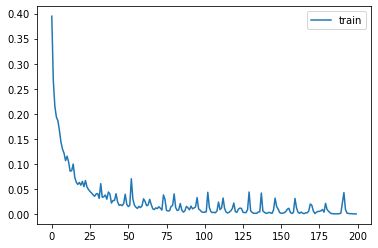

In [34]:
# plt.title('Loss Keras Model')
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

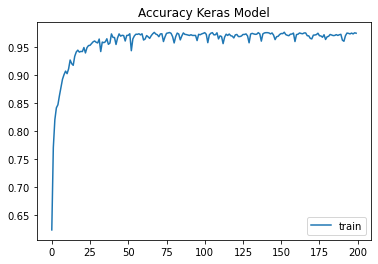

In [35]:
plt.title('Accuracy Keras Model')
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

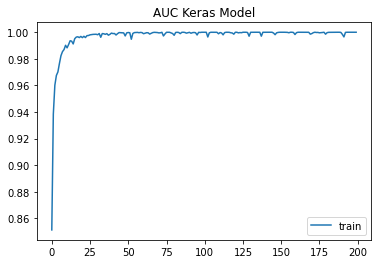

In [36]:
plt.title('AUC Keras Model')
plt.plot(history.history['auc'], label='train')
plt.legend()
plt.show()

In [37]:
x_test = np.array(X_test)

#Reshape the data into 3-D array
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))


In [38]:
y_pred = model.predict(X_test)

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [39]:
accuracy_score_val = accuracy_score(y_test, y_pred)
accuracy_score_val

0.8810703666997026

In [40]:
accuracy_score_val = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1_measure = 2 * ((precision * recall) / (precision + recall))
print('Calculated Accuracy score: {}, Precision: {}, Recall: {}, F1 measure: {} '.format(accuracy_score_val,
                                                            precision, recall, f1_measure))

Calculated Accuracy score: 0.8810703666997026, Precision: 0.9098671726755219, Recall: 0.9098671726755219, F1 measure: 0.9098671726755219 


In [41]:
from termcolor import colored

In [147]:
def get_active_targets(compounds):
    compounds_predicted = {}

    molecule_ids = df2[df2["Smiles"].isin(compounds)]["Molecule ChEMBL ID"].tolist()

    compounds = df2[df2["Smiles"].isin(compounds)]["Smiles"].tolist()
    j = 0
    for c in compounds:
        compounds_predicted[molecule_ids[j]] = { 'smile': c,'targets': [], 'prob': [] }
        j += 1
    finger_prints = df[df["Molecule ChEMBL ID"].isin(molecule_ids)]
    drop_columns =  ["Molecule ChEMBL ID"]
    n_samples_test = len(finger_prints)
    n_features = n_inputs
    i = 0
    for index, row in finger_prints.iterrows():
        r = row.to_frame().T
        m_id = r["Molecule ChEMBL ID"].iloc[0]
        new_data = r.drop(columns=drop_columns)
        new_data = np.asarray(new_data).astype(np.int)
        pred = model.predict(new_data)[0]
        for j in range(0, len(pred)):
            prob = pred[j]
            t = util_fn.target_abbr_from_id(target_ids[j])
            compounds_predicted[m_id]['targets'].append(t)
            compounds_predicted[m_id]['prob'].append(prob)
        i += 1
    
    return compounds_predicted

In [148]:
smiles = ['N#CCCCn1nc(-c2ccc(F)c(O)c2)c2c(N)ncnc21', 
          'CS(=O)(=O)N1CCN(Cc2cc3nc(-c4cccc5[nH]ncc45)nc(N4CCOCC4)c3s2)CC1',
          'Nc1ccc(-c2ccc3ncc4c(=O)[nH]c(=O)n(-c5cccc(C(F)(F)F)c5)c4c3n2)cn1',
          
             ]
finger_print = X_test.iloc[[0]]
compounds = get_active_targets(smiles)
for t in compounds:
    print(colored("Following target probabilites are predicted for Compound: \n {} \n \n".format(compounds[t]['smile']), 
                  'blue'))
    i = 0
    for target in compounds[t]['targets']:
        prob = compounds[t]['prob'][i]
        if prob >= 0.5:
            print(colored("Target {}, Probability {}% \n \n".format( target, round(prob * 100)) , 'green'))
        else:
            print(colored("Target {}, Probability {}% \n \n".format( target, round(prob * 100)) , 'red'))
        i += 1

Following target probabilites are predicted for Compound: 
 Nc1ccc(-c2ccc3ncc4c(=O)[nH]c(=O)n(-c5cccc(C(F)(F)F)c5)c4c3n2)cn1 
 

Target MIA PaCa-2, Probability 0% 
 

Target IGF-1, Probability 99% 
 

Target mTOR, Probability 100% 
 

Target EGFR-erbB1, Probability 96% 
 

Following target probabilites are predicted for Compound: 
 CS(=O)(=O)N1CCN(Cc2cc3nc(-c4cccc5[nH]ncc45)nc(N4CCOCC4)c3s2)CC1 
 

Target MIA PaCa-2, Probability 97% 
 

Target IGF-1, Probability 0% 
 

Target mTOR, Probability 100% 
 

Target EGFR-erbB1, Probability 0% 
 

Following target probabilites are predicted for Compound: 
 N#CCCCn1nc(-c2ccc(F)c(O)c2)c2c(N)ncnc21 
 

Target MIA PaCa-2, Probability 0% 
 

Target IGF-1, Probability 0% 
 

Target mTOR, Probability 100% 
 

Target EGFR-erbB1, Probability 100% 
 



In [92]:
df2[df2["Smiles"].isin(smiles)]

,Molecule ChEMBL ID,Smiles,CHEMBL614725,CHEMBL1957,CHEMBL2842,CHEMBL203
493,CHEMBL3903725,Nc1ccc(-c2ccc3ncc4c(=O)[nH]c(=O)n(-c5cccc(C(F)...,0,1,1,1
1452,CHEMBL521851,CS(=O)(=O)N1CCN(Cc2cc3nc(-c4cccc5[nH]ncc45)nc(...,1,0,1,0
2157,CHEMBL1242469,N#CCCCn1nc(-c2ccc(F)c(O)c2)c2c(N)ncnc21,0,0,1,1


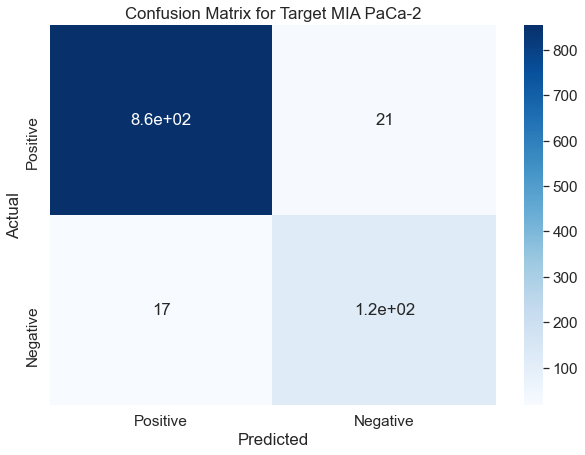

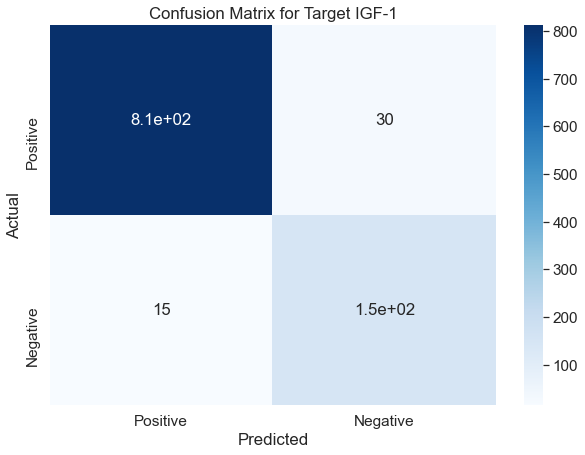

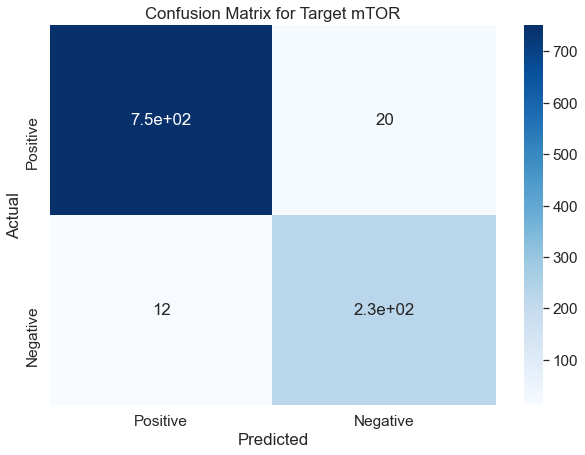

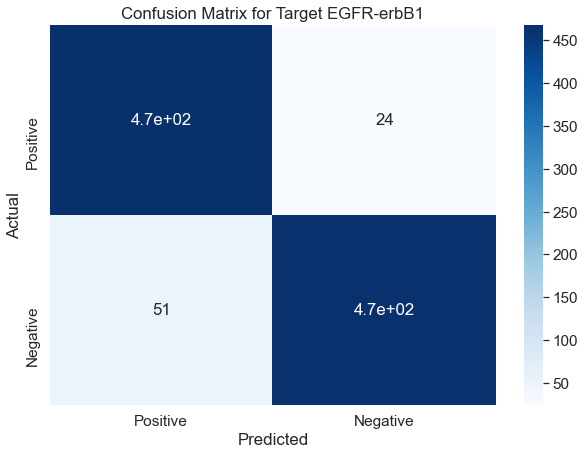

In [151]:
cm = multilabel_confusion_matrix(y_test, y_pred)
i = 0
for t in cm:
    sns.set(font_scale=1.4)#for label size
    df_cm = pd.DataFrame(t, columns=["Positive", "Negative"], index = ["Positive", "Negative"])
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    plt.title("Confusion Matrix for Target {}".format(util_fn.target_abbr_from_id(target_ids[i])))
    sns.heatmap(df_cm, cmap="Blues", annot=True)
    plt.show()
    i +=1 